### BGEN Encoding

Test that encoded float values are correct after serialization 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import zarr
from sgkit.testing import simulate_genotype_call_dataset

<AxesSubplot:>

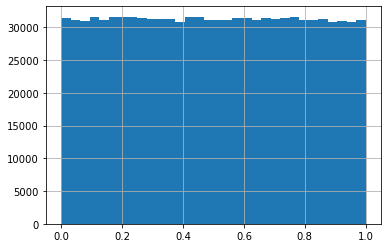

In [2]:
ds = simulate_genotype_call_dataset(10000, 100)
ds.attrs['contigs'] = [int(v) for v in ds.attrs['contigs']]
rs = np.random.RandomState(0)
shape = ds['call_genotype'].shape
ds['call_genotype'].values = np.where(rs.rand(*shape) < .5, np.nan, rs.rand(*shape))
ds['call_genotype'].values = np.where(ds['call_genotype'].values > .98, 1, ds['call_genotype'].values)
pd.Series(ds['call_genotype'].values.ravel()).hist(bins=32)

In [3]:
# Save with encoding and compression
compressor = zarr.Blosc(cname="zstd", clevel=7, shuffle=2)
ds.to_zarr('/tmp/ds.zarr', mode='w', 
           encoding={'call_genotype': dict(
               scale_factor=1/254., add_offset=-1/254., _FillValue=0, dtype='uint8',
               compressor=compressor
           )})

In [4]:
# Do not decode (e.g. as would be ideal in a rechunk op)
ds2 = xr.open_zarr('/tmp/ds.zarr', mask_and_scale=False, decode_cf=True)
ds2

<xarray.Dataset>
Dimensions:             (ploidy: 2, samples: 100, variants: 10000)
Dimensions without coordinates: ploidy, samples, variants
Data variables:
    call_genotype       (variants, samples, ploidy) uint8 dask.array<chunksize=(5000, 50, 1), meta=np.ndarray>
    call_genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(5000, 50, 1), meta=np.ndarray>
    sample_id           (samples) <U3 dask.array<chunksize=(100,), meta=np.ndarray>
    variant_allele      (variants) |S2 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_contig      (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position    (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    contigs:  [0]

In [5]:
pd.Series(ds2.call_genotype.values.ravel()).value_counts().sort_index()

0      998880
1        2001
2        3982
3        4013
4        3956
        ...  
247      3882
248      3941
249      3966
250      1595
255     19954
Length: 252, dtype: int64

In [6]:
ds2.to_zarr('/tmp/ds2.zarr', mode='w')

In [7]:
ds3 = xr.open_zarr('/tmp/ds2.zarr')
ds3

<xarray.Dataset>
Dimensions:             (ploidy: 2, samples: 100, variants: 10000)
Dimensions without coordinates: ploidy, samples, variants
Data variables:
    call_genotype       (variants, samples, ploidy) float32 dask.array<chunksize=(5000, 50, 1), meta=np.ndarray>
    call_genotype_mask  (variants, samples, ploidy) int8 dask.array<chunksize=(5000, 50, 1), meta=np.ndarray>
    sample_id           (samples) <U3 dask.array<chunksize=(100,), meta=np.ndarray>
    variant_allele      (variants) |S2 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_contig      (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position    (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    contigs:  [0]

<AxesSubplot:>

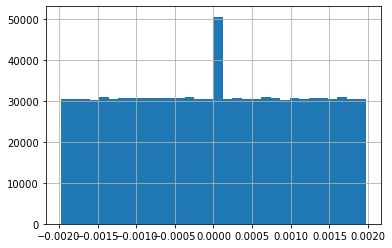

In [8]:
pd.Series((ds['call_genotype'] - ds3['call_genotype']).values.ravel()).hist(bins=32)

In [9]:
np.allclose(ds['call_genotype'], ds3['call_genotype'], equal_nan=True, atol=.01)

True